In [3]:
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
import xarray as xr
import magali as mg
import numba
import choclo

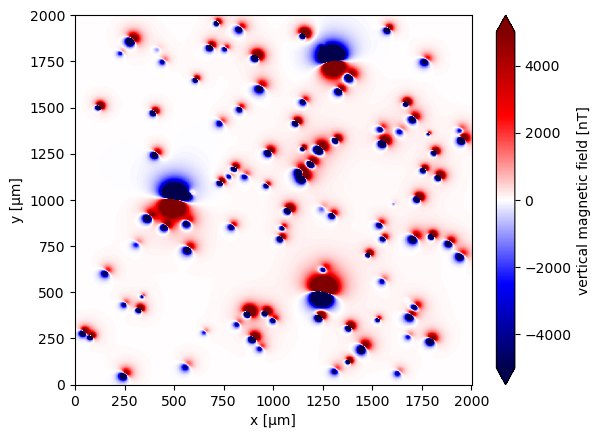

In [4]:
sensor_sample_distance = 5.0  # µm
region = [0, 2000, 0, 2000]  # µm
spacing = 2  # µm

true_inclination = 30
true_declination = 40
true_dispersion_angle = 5

size = 100

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

dipoles_amplitude = abs(np.random.normal(0, 100, size)) * 1.0e-14

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, size), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, size), [500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, size), [-15, -15, -30]]),  # µm
)
dipole_moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate([directions_inclination, [10, -10, -5]]),
    declination=np.concatenate([directions_declination, [10, 170, 190]]),
    intensity=np.concatenate([dipoles_amplitude, [5e-11, 5e-11, 5e-11]]),
)

data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)

data.plot.pcolormesh(cmap="seismic", vmin=-5000, vmax=5000)

In [5]:
coordinates = vd.grid_coordinates(
    region=region,  # µm
    spacing=spacing,  # µm
    extra_coords=sensor_sample_distance,
)

In [6]:
len(coordinates[1])

1001

In [18]:
# Copyright (c) 2024 The Magali Developers.
# Distributed under the terms of the BSD 3-Clause License.
# SPDX-License-Identifier: BSD-3-Clause
#
# This code is part of the Fatiando a Terra project (https://www.fatiando.org)
#
"""
Classes for inversions.
"""

import numpy as np
import scipy as sp
import verde.base as vdb

@numba.jit(nopython=True, parallel=True)
def _dipole_jacobian_fast(e, n, u, de, dn, du, jacobian):
    """
    This is the bit that runs the fast for-loops
    """
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)
    for i in numba.prange(e.size):
        # Calculating the distance only once saves a lot of computation time
        distance = choclo.utils.distance_cartesian(
            e[i],
            n[i],
            u[i],
            de,
            dn,
            du,
        )
        # These are the second derivatives of 1/r
        jacobian[i, 0] = constant * choclo.point.kernel_eu(
            easting_p=e[i],
            northing_p=n[i],
            upward_p=u[i],
            easting_q=de,
            northing_q=dn,
            upward_q=du,
            distance=distance,
        )
        jacobian[i, 1] = constant * choclo.point.kernel_nu(
            easting_p=e[i],
            northing_p=n[i],
            upward_p=u[i],
            easting_q=de,
            northing_q=dn,
            upward_q=du,
            distance=distance,
        )
        jacobian[i, 2] = constant * choclo.point.kernel_uu(
            easting_p=e[i],
            northing_p=n[i],
            upward_p=u[i],
            easting_q=de,
            northing_q=dn,
            upward_q=du,
            distance=distance,
        )
class MagneticMomentBz:
    def __init__(self, location):
        self.location = location
        # The estimated parameters. Start them with None
        self.dipole_moment_ = None

    def fit(self, coordinates, data):
        "data - bz vector"
        coordinates, data, _ = vdb.check_fit_input(coordinates, data, weights=None)
        x, y, z = vdb.n_1d_arrays(coordinates, 3)
        print(coordinates)
        x_c, y_c, z_c = vdb.n_1d_arrays(self.location, 3)
        n_data = data.size
        jacobian = np.empty((n_data, 3))
        _dipole_jacobian_fast(
            x * mg.MICROMETER_TO_METER,
            y * mg.MICROMETER_TO_METER,
            z * mg.MICROMETER_TO_METER,
            dipole_coordinates[0] * mg.MICROMETER_TO_METER,
            dipole_coordinates[1] * mg.MICROMETER_TO_METER,
            dipole_coordinates[2] * mg.MICROMETER_TO_METER,
            jacobian,
        )
    

            

In [19]:
inv = MagneticMomentBz(dipole_coordinates)
inv.fit(coordinates, data)

(array([[   0.,    2.,    4., ..., 1996., 1998., 2000.],
       [   0.,    2.,    4., ..., 1996., 1998., 2000.],
       [   0.,    2.,    4., ..., 1996., 1998., 2000.],
       ...,
       [   0.,    2.,    4., ..., 1996., 1998., 2000.],
       [   0.,    2.,    4., ..., 1996., 1998., 2000.],
       [   0.,    2.,    4., ..., 1996., 1998., 2000.]],
      shape=(1001, 1001)), array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   2.,    2.,    2., ...,    2.,    2.,    2.],
       [   4.,    4.,    4., ...,    4.,    4.,    4.],
       ...,
       [1996., 1996., 1996., ..., 1996., 1996., 1996.],
       [1998., 1998., 1998., ..., 1998., 1998., 1998.],
       [2000., 2000., 2000., ..., 2000., 2000., 2000.]],
      shape=(1001, 1001)), array([[5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       ...,
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.]], shape=

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(array(float64, 2d, C), Tuple(int64, Literal[int](0)), array(float64, 1d, C))
 
There are 16 candidate implementations:
[1m    - Of which 16 did not match due to:
    Overload of function 'setitem': File: <numerous>: Line N/A.
      With argument(s): '(array(float64, 2d, C), UniTuple(int64 x 2), array(float64, 1d, C))':[0m
[1m     No match.[0m
[0m
[0m[1mDuring: typing of setitem at /tmp/ipykernel_846/555445987.py (32)[0m
[1m
File "../../../../../../../tmp/ipykernel_846/555445987.py", line 32:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: Pass nopython_type_inference[0m